In [1]:
import torch
import transformer_lens.utils as utils
import plotly.express as px
import tqdm
from functools import partial
import einops
import plotly.graph_objects as go
if torch.cuda.is_available():
    device = "cuda"
# elif torch.backends.mps.is_available():
#     device = "mps"
else: 
    device = "cpu"
torch.set_grad_enabled(False)
!nvidia-smi

import os

# Suppress tqdm progress bars
tqdm.tqdm().disable = True

os.environ['TOKENIZERS_PARALLELISM'] = 'false'
def test_performance(prompt_list, answer_list, model, max_new_tokens=1, temperature=0.4):
    tokens = model.to_tokens(prompt_list, prepend_bos=True)
    op = model.generate(tokens, max_new_tokens=1, temperature=0.4)
    corr = 0
    for ind, val in enumerate(prompt_list):
        # print("Prompt: "+val)
        # print("Expected Answer: "+answer_list[ind])
        # print("Model Answer: "+ model.to_string(op[ind, -1]))
        if answer_list[ind] == model.to_string(op[ind, -1]):
            corr+=1
    return corr*100/len(prompt_list)

import random
import string

def generate_sequences(num_samples, transitive_length, fake_prob=0.5, randomize_prob=0.5):
    sequences = []
    answers = []

    for _ in range(num_samples):
        # Generate transitive sequence letters
        transitive_letters = random.sample(string.ascii_uppercase, transitive_length + 1)
        
        # Create the transitive property sequence
        transitive_relations = [(transitive_letters[i], transitive_letters[i+1]) for i in range(transitive_length)]
        
        # Randomly shuffle the transitive relations based on randomize_prob
        if random.random() < randomize_prob:
            random.shuffle(transitive_relations)
        
        # Optionally add fake sequences based on fake_prob
        fake_sequences = []
        if random.random() < fake_prob:
            num_fake_sequences = random.randint(1, 2)  # Add 1 or 2 fake sequences
            for _ in range(num_fake_sequences):
                fake_letters = random.sample(string.ascii_uppercase, 2)
                while set(fake_letters).intersection(set(transitive_letters)):
                    fake_letters = random.sample(string.ascii_uppercase, 2)
                fake_sequences.append((fake_letters[0], fake_letters[1]))

        # Combine real and fake sequences and shuffle if needed
        all_relations = transitive_relations + fake_sequences
        if random.random() < randomize_prob:
            random.shuffle(all_relations)
        
        # Create the prompt
        prompt_parts = [f"{a} leads to {b}" for a, b in all_relations]
        prompt = f"If {', '.join(prompt_parts)}, then {transitive_letters[0]} will eventually lead to <strong>"
        
        # Append to results
        sequences.append(prompt)
        answers.append(transitive_letters[-1])

    return sequences, answers

# Example usage with knobs
prompts, answers = generate_sequences(50, 5, fake_prob=0, randomize_prob=0.8)

Mon Jul  8 01:05:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:06:00.0 Off |                    0 |
| N/A   34C    P0              33W / 250W |      3MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

0it [00:00, ?it/s]

In [2]:

def logit_difference(model, answers, prompts):
    # Convert prompts to tokens
    tokens = model.to_tokens(prompts)
    logits, _ = model.run_with_cache(tokens)
    
    # Get the correct tokens for all answers at once
    correct_tokens = model.to_tokens(answers).squeeze()[:, 1]  # Select the second token (correct token) in each sequence

    # Get the logits for the last token of each prompt
    last_logits = logits[:, -1, :]

    # Get the most probable token indices for all prompts at once
    most_probable_token_indices = torch.argmax(last_logits, dim=-1)

    # Gather the logits for the most probable tokens and the correct tokens
    most_probable_logits = last_logits.gather(1, most_probable_token_indices.unsqueeze(1)).squeeze(1)
    correct_logits = last_logits.gather(1, correct_tokens.unsqueeze(1)).squeeze(1)

    # Calculate the logit differences
    logit_differences = most_probable_logits - correct_logits
    return logit_differences

def logit_difference_steered(model, logits, answers, prompts):
    
    # Get the correct tokens for all answers at once
    correct_tokens = model.to_tokens(answers).squeeze()[:, 1]  # Select the second token (correct token) in each sequence

    # Get the logits for the last token of each prompt
    last_logits = logits[:, -1, :]

    # Get the most probable token indices for all prompts at once
    most_probable_token_indices = torch.argmax(last_logits, dim=-1)

    # Gather the logits for the most probable tokens and the correct tokens
    most_probable_logits = last_logits.gather(1, most_probable_token_indices.unsqueeze(1)).squeeze(1)
    correct_logits = last_logits.gather(1, correct_tokens.unsqueeze(1)).squeeze(1)

    # Calculate the logit differences
    logit_differences = most_probable_logits - correct_logits
    return logit_differences

In [3]:
from sae_lens import HookedSAETransformer
model_gemma: HookedSAETransformer = HookedSAETransformer.from_pretrained("gemma-2b").to(device)

from sae_lens import SAE 
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

# Choose a layer you want to focus on
# For this tutorial, we're going to use layer 2
layer = 6

# get the SAE for this layer
sae, cfg_dict, _ = SAE.from_pretrained(
    release = "gemma-2b-res-jb",
    sae_id = f"blocks.{layer}.hook_resid_post",
    device = device
)

# get hook point
hook_point = sae.cfg.hook_name
print(hook_point)

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model gemma-2b into HookedTransformer
Moving model to device:  cuda
blocks.6.hook_resid_post


In [4]:
prompts, answers = generate_sequences(50, 5, fake_prob=0, randomize_prob=0.2)
test_performance(prompts, answers, model_gemma)

  0%|          | 0/1 [00:00<?, ?it/s]

62.0

In [5]:
prompts_diff, answers_diff = generate_sequences(50, 5, fake_prob=0, randomize_prob=0.8)
test_performance(prompts_diff, answers_diff, model_gemma)

  0%|          | 0/1 [00:00<?, ?it/s]

40.0

In [8]:
base_logit_diff = logit_difference(model_gemma, answers_diff, prompts_diff)
baseline_avg = base_logit_diff.mean().item()

In [9]:
baseline_avg

0.3236616551876068

In [12]:
sv_prompt = prompts[0]
sv_logits, cache = model_gemma.run_with_cache(sv_prompt, prepend_bos=True)
tokens = model_gemma.to_tokens(sv_prompt)
print(tokens)

# get the feature activations from our SAE
sv_feature_acts = sae.encode(cache[hook_point])

# get sae_out
sae_out = sae.decode(sv_feature_acts)

tensor([[     2,   2495,    586,  11845,    577,    584, 235269,    584,  11845,
            577,    590, 235269,    590,  11845,    577,    653, 235269,    653,
          11845,    577,   1274, 235269,   1274,  11845,    577,    640, 235269,
           1492,    586,    877,  13339,   2389,    577, 235248,    199]],
       device='cuda:0')


In [12]:
sv_prompt = prompts[0]
sv_logits, cache = model_gemma.run_with_cache(sv_prompt, prepend_bos=True)
tokens = model_gemma.to_tokens(sv_prompt)
print(tokens)

# get the feature activations from our SAE
sv_feature_acts = sae.encode(cache[hook_point])

# get sae_out
sae_out = sae.decode(sv_feature_acts)

top_features = torch.topk(sv_feature_acts, 50).indices.tolist()

from collections import Counter

def sort_by_frequency(nested_list):
    # Flatten the nested list
    flat_list = [item for sublist in nested_list for item in sublist]
    
    # Count the frequency of each element
    frequency_count = Counter(flat_list)
    
    # Sort elements by frequency (most frequent first) and then by the element value (if frequencies are the same)
    sorted_elements = sorted(frequency_count.keys(), key=lambda x: (-frequency_count[x], x))
    
    return sorted_elements

sorted_unique_elements = sort_by_frequency(top_features[0])
print(len(sorted_unique_elements))

result_dict = {}
steering_on = True
for feature_ind in sorted_unique_elements[:100]:
    coeff_dict = {}
    for coeff in [5, 50, 150]:
        # dict_key = str(feature_ind)+"_"+str(coeff)
        steering_vector = sae.W_dec[feature_ind]
        def steering_hook(resid_pre, hook):
            if resid_pre.shape[1] == 1:
                return

            position = sae_out.shape[1]
            if steering_on:
              # using our steering vector and applying the coefficient
              resid_pre[:, :position - 1, :] += coeff * steering_vector

        def hooked_generate(prompt_batch, fwd_hooks=[], seed=None):
            if seed is not None:
                torch.manual_seed(seed)

            with model_gemma.hooks(fwd_hooks=fwd_hooks):
                tokenized = model_gemma.to_tokens(prompt_batch)
                result, _ = model_gemma.run_with_cache(tokenized)
            return result
        
        model_gemma.reset_hooks()
        editing_hooks = [(f"blocks.{layer}.hook_resid_post", steering_hook)]
        logits = hooked_generate(prompts, editing_hooks, seed=None)
        coeff_dict[coeff] = logit_difference_steered(model_gemma, logits, answers, prompts)
        # Free up memory
        del logits
        torch.cuda.empty_cache()
    result_dict[feature_ind] = coeff_dict

tensor([[     2,   2495,    585,  11845,    577,    599, 235269,    599,  11845,
            577,    747, 235269,   1271,  11845,    577,    629, 235269,    747,
          11845,    577,   1271, 235269,    629,  11845,    577,    713, 235269,
           1492,    585,    877,  13339,   2389,    577, 235248,    199]],
       device='cuda:0')
535


In [13]:
base_logit_diff = logit_difference(model_gemma, answers, prompts)
baseline_avg = base_logit_diff.mean().item()

In [14]:
import matplotlib.pyplot as plt
# Dictionary to store average values
avg_dict = {}

# Calculate averages
for feature_ind, coeff_dict in result_dict.items():
    avg_dict[feature_ind] = {}
    for coeff, tensor in coeff_dict.items():
        avg_dict[feature_ind][coeff] = tensor.mean().item()
# Find the N feature indices with the lowest averages
N = 15  # Number of lowest averages to find
feature_min_avg_list = []

for feature_ind, coeff_dict in avg_dict.items():
    min_avg_value = min(coeff_dict.values())
    feature_min_avg_list.append((feature_ind, min_avg_value))

# Sort the features by their minimum average values
feature_min_avg_list.sort(key=lambda x: x[1])

# Get the N lowest averages
lowest_avg_features = feature_min_avg_list[:N]

print(f"The {N} feature indices with the lowest minimum average values are:")
for feature_ind, avg_value in lowest_avg_features:
    print(f"{feature_ind}: {avg_value}")



The 15 feature indices with the lowest minimum average values are:
5000: 0.009265785105526447
438: 0.01234920509159565
7923: 0.01590190827846527
5361: 0.01758529618382454
1526: 0.018461380153894424
5998: 0.018799513578414917
4531: 0.02188297174870968
5543: 0.023229559883475304
3993: 0.02482730895280838
10345: 0.027861518785357475
5002: 0.030638694763183594
14812: 0.03135078400373459
11789: 0.03151451051235199
7418: 0.0320400595664978
1086: 0.03518253192305565


In [16]:
lowest_features = [feature[0] for feature in lowest_avg_features]
lowest_features

[5000,
 438,
 7923,
 5361,
 1526,
 5998,
 4531,
 5543,
 3993,
 10345,
 5002,
 14812,
 11789,
 7418,
 1086]

In [17]:
feature_ind_dict
for feature_ind, avg_value in avg_dict.items():
    if feature_ind in lowest_features:
        print(f"{feature_ind}: {avg_value}")

5002: {5: 0.056221503764390945, 50: 0.030638694763183594, 150: 0.6010687351226807}
14812: {5: 0.059348370879888535, 50: 0.03135078400373459, 150: 0.3939533233642578}
11789: {5: 0.052753906697034836, 50: 0.03151451051235199, 150: 4.881669044494629}
7418: {5: 0.056434858590364456, 50: 0.0320400595664978, 150: 1.5528852939605713}
7923: {5: 0.053663212805986404, 50: 0.01590190827846527, 150: 0.8738734126091003}
5998: {5: 0.05722988024353981, 50: 0.018799513578414917, 150: 4.670341491699219}
1526: {5: 0.05520286411046982, 50: 0.018461380153894424, 150: 2.9563822746276855}
4531: {5: 0.052818603813648224, 50: 0.02188297174870968, 150: 0.9423927068710327}
5000: {5: 0.049994733184576035, 50: 0.009265785105526447, 150: 2.0854365825653076}
5361: {5: 0.05684219300746918, 50: 0.01758529618382454, 150: 2.0540826320648193}
438: {5: 0.05553504824638367, 50: 0.01234920509159565, 150: 2.346804618835449}
1086: {5: 0.04956432059407234, 50: 0.03518253192305565, 150: 2.4687118530273438}
3993: {5: 0.05458766

In [ ]:
# Test performance on more difficult dataset

In [23]:
lowest_features

[5000,
 438,
 7923,
 5361,
 1526,
 5998,
 4531,
 5543,
 3993,
 10345,
 5002,
 14812,
 11789,
 7418,
 1086]

In [33]:
prompts_diff, answers_diff = generate_sequences(50, 7, fake_prob=0, randomize_prob=0.8)

In [13]:
def get_steered_logit_diff(model_gemma, coeff, feature_ind, prompts_diff, answers_diff):
    result_dict_diff = {}
    steering_on = True

    # dict_key = str(feature_ind)+"_"+str(coeff)
    steering_vector = sae.W_dec[feature_ind]
    def steering_hook(resid_pre, hook):
        if resid_pre.shape[1] == 1:
            return

        position = sae_out.shape[1]
        if steering_on:
          # using our steering vector and applying the coefficient
          resid_pre[:, :position - 1, :] += coeff * steering_vector

    def hooked_generate(prompt_batch, fwd_hooks=[], seed=None):
        if seed is not None:
            torch.manual_seed(seed)

        with model_gemma.hooks(fwd_hooks=fwd_hooks):
            tokenized = model_gemma.to_tokens(prompt_batch)
            result, _ = model_gemma.run_with_cache(tokenized)
        return result

    model_gemma.reset_hooks()
    editing_hooks = [(f"blocks.{layer}.hook_resid_post", steering_hook)]
    logits = hooked_generate(prompts_diff, editing_hooks, seed=None)
    steered_logit_diff = logit_difference_steered(model_gemma, logits, answers_diff, prompts_diff)
    # Free up memory
    del logits
    torch.cuda.empty_cache()
    return steered_logit_diff

In [14]:
get_steered_logit_diff(model_gemma, 5, 5000, prompts_diff, answers_diff)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2919, 0.0000, 0.0000,
        0.0000, 0.9222, 1.3506, 0.0000, 0.0093, 0.4311, 0.7878, 0.5653, 1.0030,
        0.2379, 0.0000, 0.0000, 0.5056, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.2501, 0.0000, 0.4471, 1.0482, 0.0000, 1.0978, 1.0760, 0.2725, 0.6704,
        0.0000, 0.4741, 0.0000, 0.3561, 1.0465, 0.0000, 0.4445, 0.3977, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0752, 0.3837], device='cuda:0')

In [40]:
avg_dict_diff

{5000: {5: 0.39466071128845215, 50: 0.32179775834083557},
 438: {5: 0.40895694494247437, 50: 0.4918830096721649},
 7923: {5: 0.4008901119232178, 50: 0.4388233721256256},
 5361: {5: 0.4035387337207794, 50: 0.22332504391670227},
 1526: {5: 0.40958812832832336, 50: 0.5990027785301208},
 5998: {5: 0.4201814532279968, 50: 0.48414140939712524},
 4531: {5: 0.41428342461586, 50: 0.376596599817276},
 5543: {5: 0.40370237827301025, 50: 0.3890918791294098},
 3993: {5: 0.3906154930591583, 50: 0.3372533321380615},
 10345: {5: 0.4331032335758209, 50: 0.5024751424789429},
 5002: {5: 0.40390026569366455, 50: 0.3265219032764435},
 14812: {5: 0.42493537068367004, 50: 0.35091185569763184},
 11789: {5: 0.394167959690094, 50: 0.23910434544086456},
 7418: {5: 0.4058595895767212, 50: 0.3924165666103363},
 1086: {5: 0.375796914100647, 50: 0.3121092617511749}}

In [22]:
base_logit_diff = logit_difference(model_gemma, answers_diff, prompts_diff)
baseline_avg = base_logit_diff.mean().item()

In [23]:
baseline_avg

0.3236616551876068

In [ ]:
prompts, answers = generate_sequences(50, 10, fake_prob=0, randomize_prob=0.2)

In [38]:
# Summarize everything

In [19]:
lowest_features = [5000,
 438,
 7923,
 5361,
 1526,
 5998,
 4531,
 5543,
 3993,
 10345,
 5002,
 14812,
 11789,
 7418,
 1086]

In [29]:
prompts_diff[0], answers_diff[0]

('If F leads to P, H leads to W, P leads to J, V leads to H, W leads to F, then V will eventually lead to <strong>',
 'J')

In [ ]:
# prompts, answers = generate_sequences(50, 5, fake_prob=0, randomize_prob=0.2)
logit_diff = logit_difference(model_gemma, prompts_diff, answers)
print(logit_diff)

In [28]:
prompts[0], answers[0]

('If Q leads to C, C leads to F, F leads to L, L leads to X, X leads to K, then Q will eventually lead to <strong>',
 'K')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the ranges for parameters
transitive_length_values = [2, 4, 6, 8, 10]
randomize_prob_values = [0.2, 0.4, 0.6, 0.8]

# Collect results for plotting
results = {}

avg_base_logit_diff = []
for transitive_length in transitive_length_values:
    for randomize_prob in randomize_prob_values:
        prompts, answers = generate_sequences(50, transitive_length, fake_prob=0, randomize_prob=randomize_prob)
        logit_diff = logit_difference(model_gemma, answers, prompts)
        avg_base_logit_diff.append(logit_diff.mean().item())
results['baseline'] = avg_base_logit_diff

# Calculate averages and store results
for feature_ind in lowest_features:
    for coeff in [5, 50]:
        avg_logit_diff = []
        for transitive_length in transitive_length_values:
            for randomize_prob in randomize_prob_values:
                prompts, answers = generate_sequences(50, transitive_length, fake_prob=0, randomize_prob=randomize_prob)
                logit_diff = get_steered_logit_diff(model_gemma, coeff, feature_ind, prompts, answers)
                avg_logit_diff.append(logit_diff.mean().item())
        results[f"{feature_ind}_{coeff}"] = avg_logit_diff



In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Define the ranges for parameters
transitive_length_values = [2, 4, 6, 8, 10]
randomize_prob_values = [0.2, 0.4, 0.6, 0.8]

# Collect results for plotting
results = {'baseline': {}}

# Collect baseline results
for transitive_length in transitive_length_values:
    for randomize_prob in randomize_prob_values:
        prompts, answers = generate_sequences(50, transitive_length, fake_prob=0, randomize_prob=randomize_prob)
        logit_diff = logit_difference(model_gemma, answers, prompts)
        if transitive_length not in results['baseline']:
            results['baseline'][transitive_length] = {}
        results['baseline'][transitive_length][randomize_prob] = logit_diff.mean().item()

print("reached_here")
# Calculate averages and store results
for feature_ind in lowest_features:
    for coeff in [5, 50]:
        key = f"{feature_ind}_{coeff}"
        results[key] = {}
        print(key)
        for transitive_length in transitive_length_values:
            for randomize_prob in randomize_prob_values:
                prompts, answers = generate_sequences(50, transitive_length, fake_prob=0, randomize_prob=randomize_prob)
                logit_diff = get_steered_logit_diff(model_gemma, coeff, feature_ind, prompts, answers)
                if transitive_length not in results[key]:
                    results[key][transitive_length] = {}
                results[key][transitive_length][randomize_prob] = logit_diff.mean().item()

In [ ]:
results

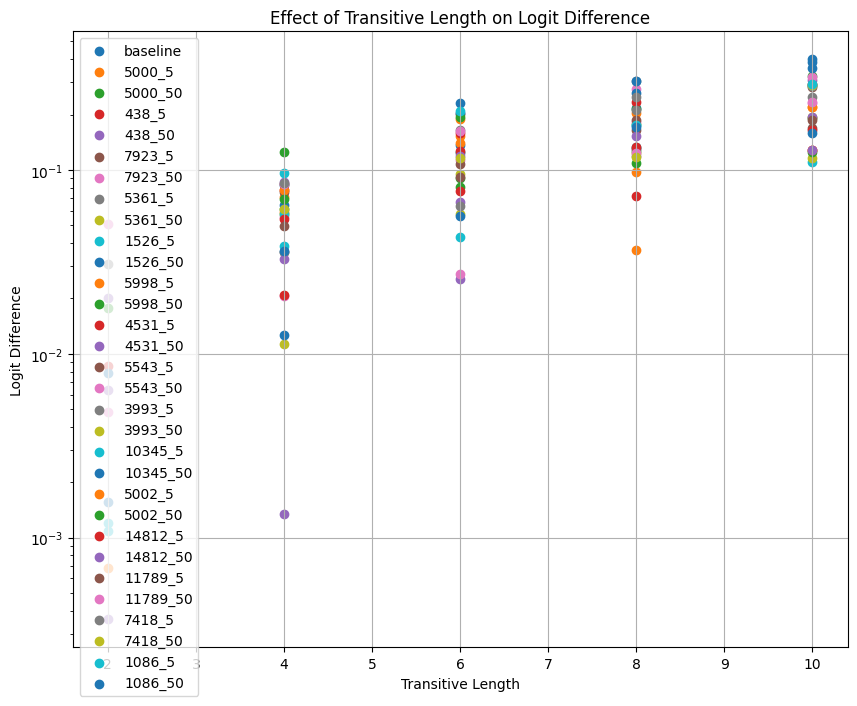

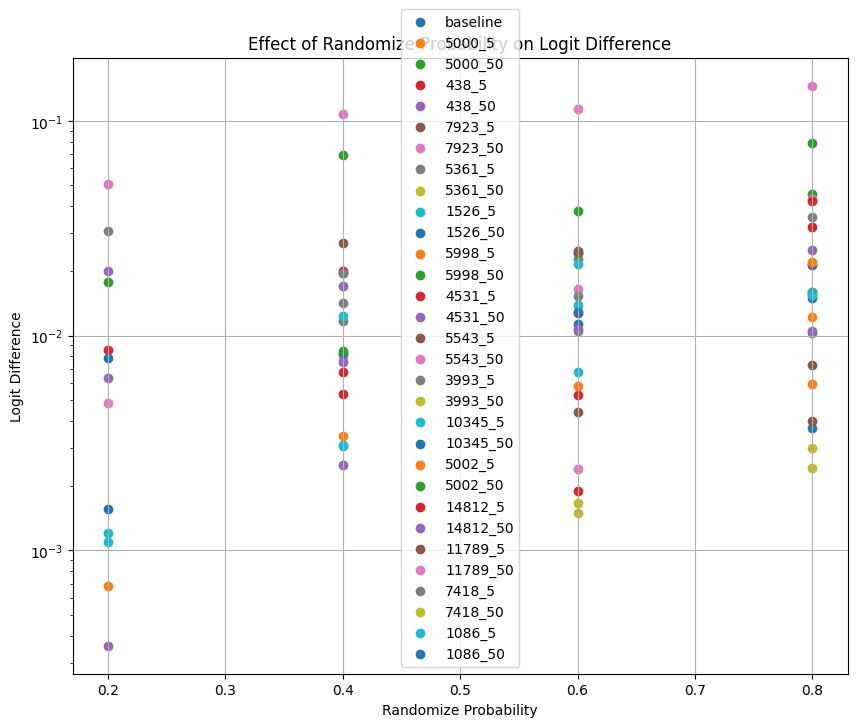

In [41]:
# Prepare data for plotting
transitive_len_vs_logit_diff = {}
randomize_prob_vs_logit_diff = {}

for key, value in results.items():
    transitive_len_vs_logit_diff[key] = [value[tl][rp] for tl in transitive_length_values for rp in [randomize_prob_values[0]]]
    randomize_prob_vs_logit_diff[key] = [value[tl][rp] for rp in randomize_prob_values for tl in [transitive_length_values[0]]]

# Plot 1: Transitive Length vs. Logit Difference
fig, ax = plt.subplots(figsize=(10, 8))
x_vals = transitive_length_values
for label, y_vals in transitive_len_vs_logit_diff.items():
    ax.scatter(x_vals, y_vals, marker='o', label=label)
ax.set_xlabel('Transitive Length')
ax.set_ylabel('Logit Difference')
ax.set_yscale("log")
ax.set_title('Effect of Transitive Length on Logit Difference')
ax.legend()
ax.grid(True)

# Plot 2: Randomize Probability vs. Logit Difference
fig, ax = plt.subplots(figsize=(10, 8))
x_vals = randomize_prob_values
for label, y_vals in randomize_prob_vs_logit_diff.items():
    ax.scatter(x_vals, y_vals, marker='o', label=label)
ax.set_xlabel('Randomize Probability')
ax.set_ylabel('Logit Difference')
ax.set_yscale("log")
ax.set_title('Effect of Randomize Probability on Logit Difference')
ax.legend()
ax.grid(True)

plt.show()


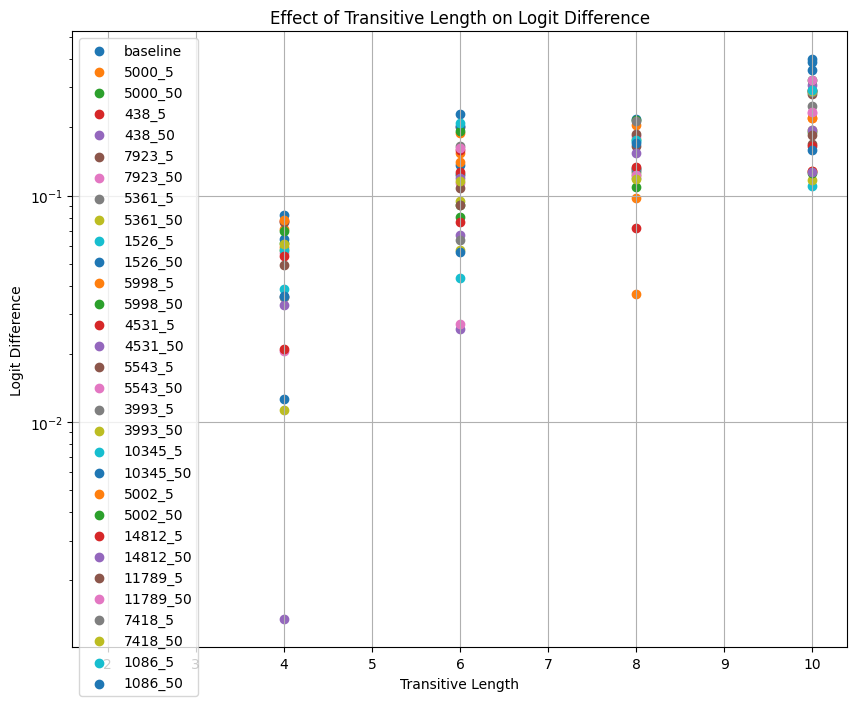

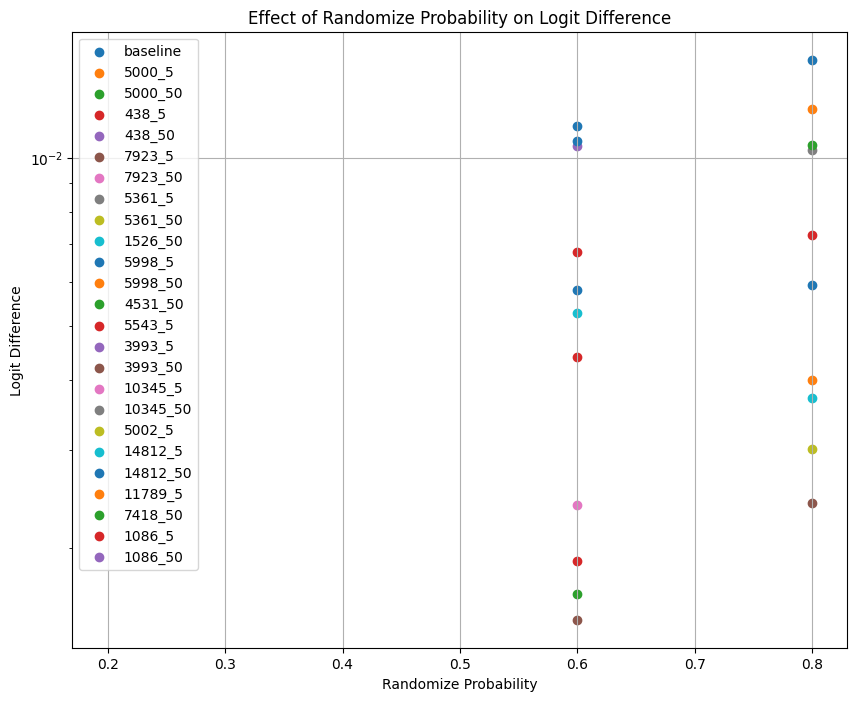

In [44]:
# Prepare data for plotting
transitive_len_vs_logit_diff = {}
randomize_prob_vs_logit_diff = {}

# Calculate averages and store results
for key, value in results.items():
    transitive_len_vs_logit_diff[key] = []
    randomize_prob_vs_logit_diff[key] = []

    for transitive_length in transitive_length_values:
        for randomize_prob in randomize_prob_values:
            diff = value[transitive_length][randomize_prob]
            baseline_diff = results['baseline'][transitive_length][randomize_prob]
            if diff <= baseline_diff:
                if randomize_prob == randomize_prob_values[0]:
                    transitive_len_vs_logit_diff[key].append((transitive_length, diff))
                if transitive_length == transitive_length_values[0]:
                    randomize_prob_vs_logit_diff[key].append((randomize_prob, diff))

# Plot 1: Transitive Length vs. Logit Difference
fig, ax = plt.subplots(figsize=(10, 8))
for label, data in transitive_len_vs_logit_diff.items():
    x_vals, y_vals = zip(*data) if data else ([], [])
    if x_vals:
        ax.scatter(x_vals, y_vals, marker='o', label=label)
ax.set_xlabel('Transitive Length')
ax.set_ylabel('Logit Difference')
ax.set_yscale("log")
ax.set_title('Effect of Transitive Length on Logit Difference')
ax.legend()
ax.grid(True)

# Plot 2: Randomize Probability vs. Logit Difference
fig, ax = plt.subplots(figsize=(10, 8))
for label, data in randomize_prob_vs_logit_diff.items():
    x_vals, y_vals = zip(*data) if data else ([], [])
    if x_vals:
        ax.scatter(x_vals, y_vals, marker='o', label=label)
ax.set_xlabel('Randomize Probability')
ax.set_ylabel('Logit Difference')
ax.set_yscale("log")
ax.set_title('Effect of Randomize Probability on Logit Difference')
ax.legend()
ax.grid(True)

plt.show()


In [ ]:
# Plot 1: Transitive Length vs. Logit Difference
fig, ax = plt.subplots(figsize=(10, 8))
x_vals = transitive_length_values
for label, y_vals in results.items():
    ax.plot(x_vals, y_vals[:len(transitive_length_values)], label=label)
ax.set_xlabel('Transitive Length')
ax.set_ylabel('Logit Difference')
ax.set_title('Effect of Transitive Length on Logit Difference')
ax.legend()
ax.grid(True)

# Plot 2: Randomize Probability vs. Logit Difference
fig, ax = plt.subplots(figsize=(10, 8))
x_vals = randomize_prob_values
for label, y_vals in results.items():
    ax.plot(x_vals, y_vals[len(transitive_length_values):], label=label)
ax.set_xlabel('Randomize Probability')
ax.set_ylabel('Logit Difference')
ax.set_title('Effect of Randomize Probability on Logit Difference')
ax.legend()
ax.grid(True)

plt.show()